In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import sys
!{sys.executable} -m pip install xgboost

# Context
This data given by an airline organization. The actual name of the company is not given due to various purposes that's why the name Invistico airlines.

The dataset consists of the details of customers who have already flown with them. The feedback of the customers on various context and their flight data has been consolidated.

The main purpose of this dataset is to predict whether a future customer would be satisfied with their service given the details of the other parameters values.

Also the airlines need to know on which aspect of the services offered by them have to be emphasized more to generate more satisfied customers.

### Overall strategy
1/ Load Dataset

2/ EDA

3/ Data cleaning

4/ Modeling
- Logistic Regression: 75%
- Decision tree (max_dept = 3) : 76%
- Random Forest (n_estimators = 100): 92%
- XGBoost: 91%
- SVC: 76%

5/ Tuning Parameters

# LOAD DATASET

In [3]:
data = pd.read_csv("C:\\Users\\17144\\Documents\\DS\\SAURABH\\projects\\airlines\\Invistico_Airline.csv")

In [4]:
data.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [5]:
df = pd.DataFrame(data= data)

# EDA

In [6]:
df.shape

(129880, 23)

In [7]:
df.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [9]:
df.isnull().sum()[df.isnull().sum()>0]

Arrival Delay in Minutes    393
dtype: int64

In [10]:
df.isnull().sum()[df.isnull().sum() >0]/len(df) * 100

Arrival Delay in Minutes    0.302587
dtype: float64

In [11]:
# treat null in Arrival Delay in Minutes column
df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].mean(), inplace=True)

In [12]:
df['Arrival Delay in Minutes'].isnull().any()

False

In [13]:
#check for imbalance data
df['satisfaction'].value_counts(normalize= True)

satisfied       0.547328
dissatisfied    0.452672
Name: satisfaction, dtype: float64

<AxesSubplot:xlabel='satisfaction', ylabel='count'>

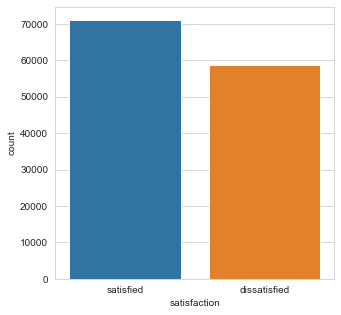

In [14]:
fig= plt.figure(figsize= (5,5))
sns.set_style('whitegrid')
sns.countplot(x=df['satisfaction'])

Handling object columns: Customer Type, Type of Travel, Class, Gender, satisfaction

In [15]:
df.dtypes[df.dtypes=='object']

satisfaction      object
Gender            object
Customer Type     object
Type of Travel    object
Class             object
dtype: object

In [16]:
len(df.dtypes[df.dtypes=='object'])

5

In [17]:
df['Customer Type'].value_counts()

Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64

In [18]:
df['Type of Travel'].value_counts()

Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64

In [19]:
df['Class'].value_counts()

Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64

In [20]:
df['Gender'].value_counts()

Female    65899
Male      63981
Name: Gender, dtype: int64

In [21]:
df['satisfaction'].value_counts()

satisfied       71087
dissatisfied    58793
Name: satisfaction, dtype: int64

Preprocessing data types by sklearn

In [22]:
def object_cols(df):
    return list(df.select_dtypes(include= 'object').columns)
def numerical_cols(df):
    return list(df.select_dtypes(exclude='object').columns)

In [23]:
obj_col= object_cols(df)
obj_col

['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class']

In [24]:
num_col = numerical_cols(df)
num_col

['Age',
 'Flight Distance',
 'Seat comfort',
 'Departure/Arrival time convenient',
 'Food and drink',
 'Gate location',
 'Inflight wifi service',
 'Inflight entertainment',
 'Online support',
 'Ease of Online booking',
 'On-board service',
 'Leg room service',
 'Baggage handling',
 'Checkin service',
 'Cleanliness',
 'Online boarding',
 'Departure Delay in Minutes',
 'Arrival Delay in Minutes']

### Normalization and Label Encoding
There are two different lists. One is object list, need to be encoded by using LabelEncoder.
another one is numerical list, need to be normalize by using Normalize method

In [25]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer

In [26]:
label_encode = LabelEncoder()
norm = Normalizer()

In [27]:
for col in obj_col:
    df[col] = label_encode.fit_transform(df[col])

In [28]:
df['Class'].unique()

array([1, 0, 2])

In [29]:
df[num_col]= norm.fit_transform(df[num_col])

In [30]:
df.head(2)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,0,0,0.238073,1,1,0.970605,0.0,0.0,0.0,...,0.007325,0.010988,0.010988,0.000000,0.010988,0.018313,0.010988,0.007325,0.000000,0.000000
1,1,1,0,0.018781,1,0,0.984599,0.0,0.0,0.0,...,0.000799,0.001199,0.001598,0.001598,0.001598,0.000799,0.001199,0.000799,0.123874,0.121876


### OUTLIERS DETECTION

ValueError: num must be 1 <= num <= 18, not 19

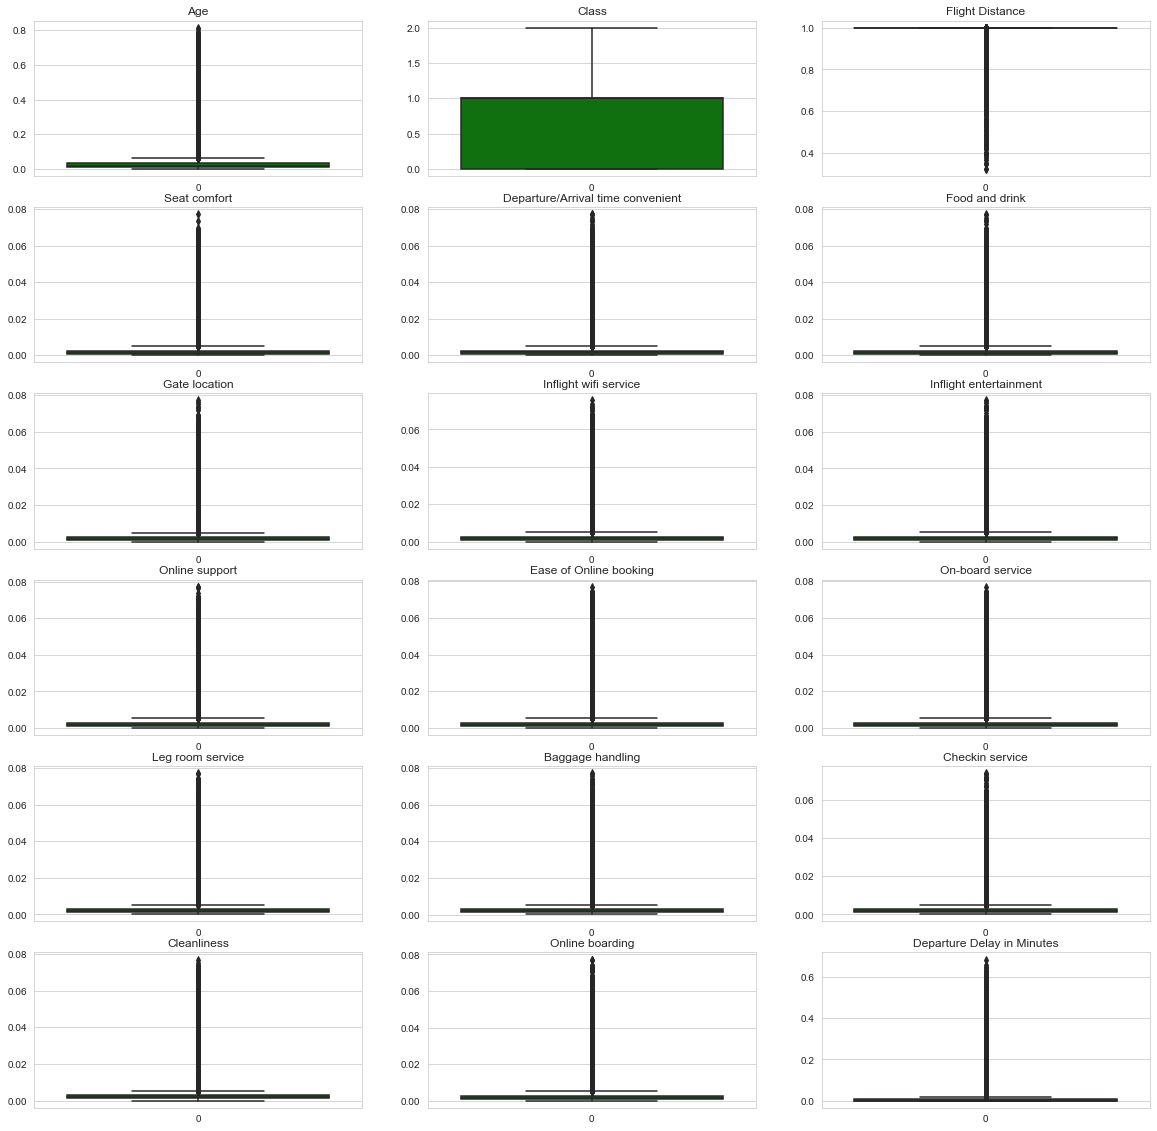

In [31]:
df_X= df.drop('satisfaction', axis=1).copy()
nonbinary_columns = [col for col in df_X.columns if len (df_X[col].unique())> 2]

plt.figure(figsize= (20,20))

for i, col in enumerate(nonbinary_columns):
    plt.subplot(6,3, i+1)
    sns.boxplot(data= df_X[col], color='green')
    plt.title(col)
plt.suptitle("Boxplots detecting Outliers", size = 20)
plt.show()

There are 4 columns has outliers: Onboard_service, Checking_service, Departure Delay in Minutes, Arrival Delay in Mintes.
I will explore these columns


In [32]:
df['On-board service'].unique()

array([0.01098798, 0.00159837, 0.00140313, ..., 0.00171532, 0.00121604,
       0.0011587 ])

In [33]:
df['Checkin service'].unique()

array([0.0183133 , 0.00079919, 0.00187084, ..., 0.00085766, 0.00081069,
       0.00069522])

### Finding and Handling outliers with IQR

mean of outlier columns before computattion

In [34]:
df['On-board service'].mean()

0.0031870649821758024

In [35]:
df['Checkin service'].mean()

0.002981381282583678

In [36]:
df['Departure Delay in Minutes'].mean()

0.010244832482795016

In [37]:
df['Arrival Delay in Minutes'].mean()

0.010639997250247245

In [38]:
outlier_cols = ['On-board service','Checkin service', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

In [39]:
Q1 = df[outlier_cols].quantile(0.05)
Q3 = df[outlier_cols].quantile(0.95)
IQR = Q3 - Q1

df = df[~((df[outlier_cols] < (Q1-1.5*IQR)) | (df[outlier_cols]> (Q3 + 1.5*IQR))).any(axis=1)]

checking mean of outlier columns after computation

In [40]:
df['On-board service'].mean()

0.002658169687114738

In [41]:
df['Checkin service'].mean()

0.0025242884616224256

In [42]:
df['Departure Delay in Minutes'].mean()

0.00775118832028069

In [43]:
df['Arrival Delay in Minutes'].mean()

0.007984136493965259

In [46]:
#need to check again, it doesnt work
outliers = []
def detect_outliers_iqr(df):
    df = sorted(df)
    q1 = np.percentile(df, 25)
    q3 = np.percentile(df, 75)
    IQR = q3 -q1
    lwr_bound = q1 -(1.5*IQR)
    upr_bound = q3 + (1.5*IQR)
    
    for i in df:
        if (i < lwr_bound or i > upr_bound):
            outliers.append(i)
    return outliers

In [47]:
#outliers_ = detect_outliers_iqr(df)

### Correlation

In [48]:
corr_mat= df.corr()

In [49]:
print(corr_mat['satisfaction'].sort_values(ascending= False))

satisfaction                         1.000000
Ease of Online booking               0.246635
Inflight entertainment               0.236736
On-board service                     0.227756
Leg room service                     0.216899
Online boarding                      0.209781
Online support                       0.205664
Cleanliness                          0.204312
Baggage handling                     0.202755
Checkin service                      0.198929
Seat comfort                         0.175224
Inflight wifi service                0.159548
Age                                  0.125824
Food and drink                       0.122408
Gate location                        0.093587
Departure/Arrival time convenient    0.082858
Departure Delay in Minutes          -0.050610
Flight Distance                     -0.052690
Arrival Delay in Minutes            -0.061619
Type of Travel                      -0.112287
Gender                              -0.212686
Class                             

In [50]:
# sort values without duplicates
# Retain upper triangular values of correlation matrix and
# make Lower triangular values Null
upper_corr_mat = corr_mat.where(np.triu(np.ones(corr_mat.shape), k=1).astype(np.bool))

# convert to 1_D series and drop Null values
unique_corr_pairs = upper_corr_mat.unstack().dropna()

#Sort correlation pairs
sorted_mat = unique_corr_pairs.sort_values()
print(sorted_mat.head(15))

Flight Distance                    Age               -0.825217
Inflight entertainment             Flight Distance   -0.706498
Online support                     Flight Distance   -0.706272
Inflight wifi service              Flight Distance   -0.682142
Online boarding                    Flight Distance   -0.666952
Gate location                      Flight Distance   -0.660048
Leg room service                   Flight Distance   -0.648908
Baggage handling                   Flight Distance   -0.646877
Departure/Arrival time convenient  Flight Distance   -0.644683
Ease of Online booking             Flight Distance   -0.634002
Cleanliness                        Flight Distance   -0.631300
On-board service                   Flight Distance   -0.629155
Seat comfort                       Flight Distance   -0.623177
Food and drink                     Flight Distance   -0.620425
Checkin service                    Flight Distance   -0.607317
dtype: float64


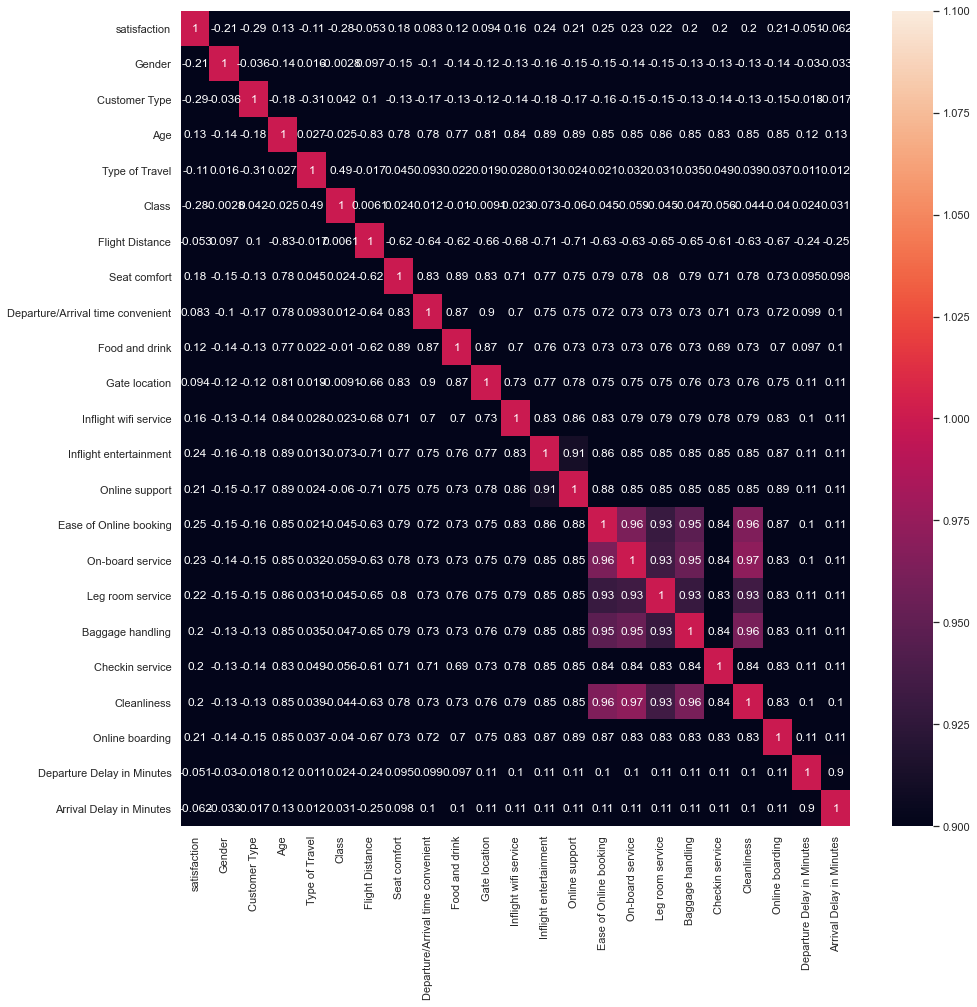

In [51]:
sns.set(rc={'figure.figsize':(15,15)})
df_heatmap = sns.heatmap(df.corr(), vmax=1, vmin= 1, annot= True)
plt.show()

In [52]:
# drop less correlation variables
drop_cols= ['Gate location', 'Departure/Arrival time convenient', 'Departure Delay in Minutes', 
            'Flight Distance', 'Arrival Delay in Minutes', 'Type of Travel' ]

In [53]:
df.drop(drop_cols, axis= 1, inplace= True)

In [54]:
df.shape

(126869, 17)

# Training with outlier handling and drop less correlation columns

In [55]:
X = df.drop(['satisfaction'], axis= 1)
y = df['satisfaction']

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn import tree

In [57]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.25, random_state= 37)

## Training data with Logistic Regression model

In [58]:
log_reg_clf = LogisticRegression()

In [59]:
log_reg_clf.fit(X_train, y_train)

LogisticRegression()

In [60]:
lr_y_pred = log_reg_clf.predict(X_test)

## Measuring Model Performance

In [61]:
# accurary metric on test dataset
score = log_reg_clf.score(X_test, y_test)
score

0.7555961914370389

In [62]:
# accuracy on train dataset
score_train = log_reg_clf.score(X_train, y_train)
score_train

0.7524776408025139

In [63]:
# confusion metric
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, lr_y_pred)
cm

array([[10105,  4393],
       [ 3359, 13861]], dtype=int64)

Confusion matrix results say there are 
10105 (TP) of them were correctly classified as positive   
4393 (FP) of them were incorrectly classfied as positive
3359 (FN ) of them were incorrectly classfied as negative
13861 (TN) of them were correctly classified as negative

In [64]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, lr_y_pred, average='binary')

0.7593404185384025

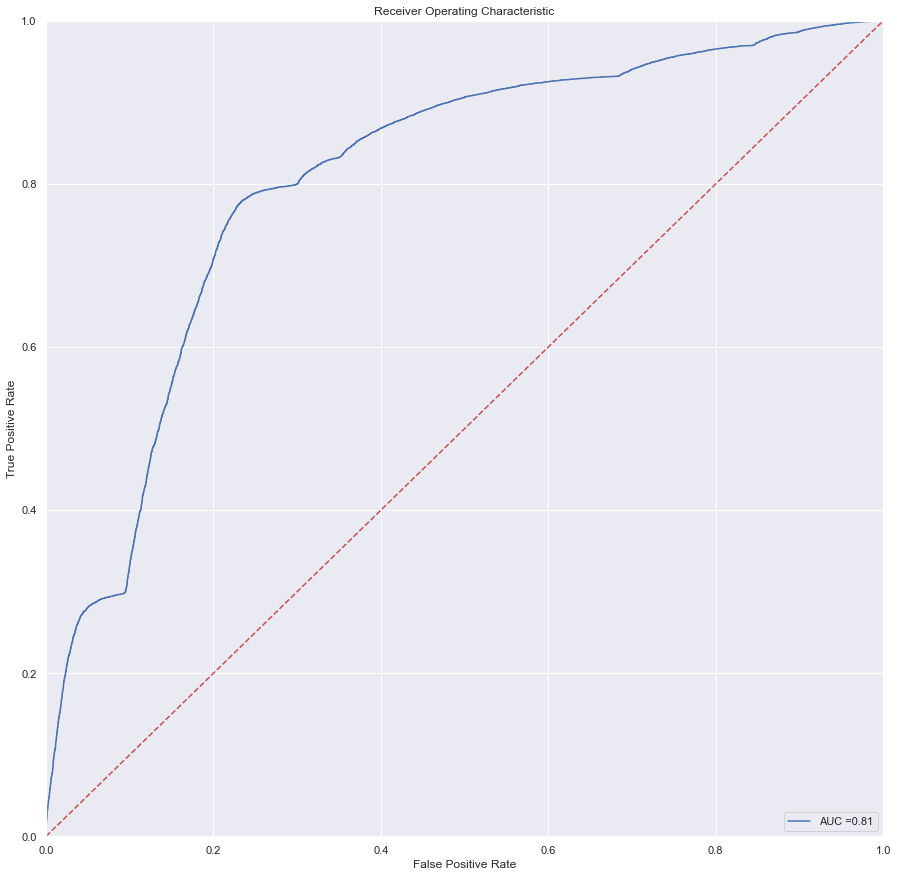

In [65]:
#ROC curve
probs = log_reg_clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

#plot the curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label ="AUC =%0.2f" %roc_auc)
plt.legend(loc ='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [66]:
roc_auc_score(y_test, lr_y_pred)

0.7509644047182447

# Training data with XGBoost

In [67]:
XGB_clf = XGBClassifier()

In [68]:
XGB_clf.fit(X_train, y_train)

[12:15:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [69]:
xgb_y_pred = XGB_clf.predict(X_test)

In [70]:
#evaluate predictions
xgb_score = accuracy_score(y_test, xgb_y_pred)
xgb_score

0.9142127498581247

#### Evaluate XGBoost Models With k-Fold Cross Validation

In [71]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [72]:
kfold = StratifiedKFold(n_splits=10, random_state=7)
results = cross_val_score(XGB_clf, X_train, y_train, cv=kfold)
print("Training Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

[12:15:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:15:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

# Training data with Decision Tree Classifier

In [73]:
tree_clf = DecisionTreeClassifier(max_depth = 3)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [74]:
#predict response for test dataset
tree_y_pred =tree_clf.predict(X_test)

Evaluating Model

In [75]:
print('Test Acuraccy:', metrics.accuracy_score(y_test, tree_y_pred))

Test Acuraccy: 0.7615549530235197


Visualize Decision Tree

In [76]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [77]:
pip install pydotplus

Note: you may need to restart the kernel to use updated packages.


In [78]:
#fig, ax = plt.subplots(figsize=(10, 10))
#tree.plot_tree(tree_clf, fontsize=10)
#plt.show()

# Training data with Random Forest Classifier
- visualize important features

In [79]:
rf_clf = RandomForestClassifier(n_estimators = 100, random_state= 37)

In [80]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=37)

In [ ]:
ada_clf = AdaBoostClassifier()

In [ ]:
ada_clf.fit(X_train, y_train)

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset 
and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction.

In [ ]:
bagging_clf = BaggingClassifier()

In [ ]:
bagging_clf.fit(X_train, y_train)

In [ ]:
gb_clf = GradientBoostingClassifier()

In [ ]:
gb_clf.fit(X_train, y_train)

In [ ]:
ensemble_model = [rf_clf, ada_clf, bagging_clf, gb_clf]
for m in ensemble_model:
    pred = m.predict(X_test)
    print('%f is the accuracy score for %s'%(accuracy_score(y_test,pred),m))

In [ ]:
X.columns

In [ ]:
for i in enumerate(X.columns):
    print (i)

In [ ]:
#FIND BEST FEATURES
key_features= rf_clf.feature_importances_
key_features_series = pd.Series(key_features)
key_features_series = pd.to_numeric(key_features_series, errors= 'coerce')
key_features_series.sort_values(ascending = False)

Base on the above result. Top 5 important features are:  Inflight entertainment, Seat comfort, Class, Food and Drink and Age

# Train with SVC

In [ ]:
svc_clf = SVC()

In [ ]:
svc_clf.fit(X_train, y_train)

In [ ]:
svc_y_pred = svc_clf.predict(X_test)

In [ ]:
print('SVC Score:', accuracy_score(y_test, svc_y_pred) )

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, svc_y_pred)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Predicting Satisfaction')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

# Hyperparameter Optimization SVC using GridSearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
svc = SVC()

In [ ]:
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']},
               {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]
grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
grid_search.fit(X_train, y_train)

# Tune Hyperparameters for better performance- in processing

# Logistic Regression 
- tuning C = [0.001,0.01,0.1,1,10,100]
- Parameter C will work the other way around. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we low the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data.
# Decision Tree Classifier
- tuning max_features, max_leaf_nodes, min_samples_leaf, min_samples_split
# Random Forest
- the most important parameter is the number of random fatures to sample at each split point(max_features). Here I try a range of integer values for all the number of input features. (or 1 to half)
- another important parameter for random forest is the number of trees(n_estimators). Ideally, this should be increased until no further improvement is seen in the model.
# XGBoost

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
    'n_estimators': [100,500,  700],
    'max_features': ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator=rf_clf,param_grid=param_grid, cv= 5,scoring='accuracy')
CV_rfc.fit(X_train, y_train)
print('Best parameter:', CV_rfc.best_params_)
print("accuracy :",CV_rfc.best_score_*100)

In [ ]:
# make predictions on test data 
grid_predictions = CV_rfc.predict(X_test) 
test_accuracy=accuracy_score(y_test,grid_predictions)*100
print("Accuracy for our testing dataset with tuning is : {:.2f}%".format(test_accuracy) )

## Deep learning

In [81]:
pip install keras 

Note: you may need to restart the kernel to use updated packages.


In [82]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [99]:
df.shape

(126869, 17)

In [103]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [111]:
deep_model = Sequential()
deep_model.add(Dense(53, input_dim=16, activation = 'relu'))
deep_model.add(Dense(11, activation = 'relu'))
deep_model.add(Dense(8, activation= 'relu'))
deep_model.add(Dense(1, activation= 'sigmoid'))

In [113]:
deep_model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics =['accuracy'])
deep_model.fit(X_train, y_train, epochs= 250, batch_size=16)

Epoch 1/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2522 - accuracy: 0.8909
Epoch 2/250
5947/5947 [==============================] - 7s 1ms/step - loss: 0.2510 - accuracy: 0.8916
Epoch 3/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2501 - accuracy: 0.8914
Epoch 4/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2516 - accuracy: 0.8914
Epoch 5/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2503 - accuracy: 0.8907
Epoch 6/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2507 - accuracy: 0.8912
Epoch 7/250
5947/5947 [==============================] - 7s 1ms/step - loss: 0.2493 - accuracy: 0.8910
Epoch 8/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2485 - accuracy: 0.8924
Epoch 9/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2505 - accuracy: 0.8915
Epoch 10/250
5947/5947 [==============================] - 6s 1ms/step - l

5947/5947 [==============================] - 6s 1ms/step - loss: 0.2404 - accuracy: 0.8962
Epoch 80/250
5947/5947 [==============================] - 7s 1ms/step - loss: 0.2412 - accuracy: 0.8947
Epoch 81/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2398 - accuracy: 0.8956
Epoch 82/250
5947/5947 [==============================] - 6s 981us/step - loss: 0.2400 - accuracy: 0.8949
Epoch 83/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2393 - accuracy: 0.8969
Epoch 84/250
5947/5947 [==============================] - 6s 992us/step - loss: 0.2402 - accuracy: 0.8959
Epoch 85/250
5947/5947 [==============================] - 6s 999us/step - loss: 0.2389 - accuracy: 0.8960
Epoch 86/250
5947/5947 [==============================] - 6s 992us/step - loss: 0.2399 - accuracy: 0.8958
Epoch 87/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2394 - accuracy: 0.8963
Epoch 88/250
5947/5947 [==============================] - 6s 1ms/step

5947/5947 [==============================] - 6s 986us/step - loss: 0.2341 - accuracy: 0.8975
Epoch 157/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2344 - accuracy: 0.8987
Epoch 158/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2335 - accuracy: 0.8986
Epoch 159/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2342 - accuracy: 0.8984
Epoch 160/250
5947/5947 [==============================] - 6s 981us/step - loss: 0.2337 - accuracy: 0.8984
Epoch 161/250
5947/5947 [==============================] - 6s 986us/step - loss: 0.2333 - accuracy: 0.8979
Epoch 162/250
5947/5947 [==============================] - 6s 994us/step - loss: 0.2339 - accuracy: 0.8987
Epoch 163/250
5947/5947 [==============================] - 6s 997us/step - loss: 0.2337 - accuracy: 0.8982
Epoch 164/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2345 - accuracy: 0.8982
Epoch 165/250
5947/5947 [==============================] - 

5947/5947 [==============================] - 6s 972us/step - loss: 0.2304 - accuracy: 0.9008
Epoch 234/250
5947/5947 [==============================] - 6s 979us/step - loss: 0.2295 - accuracy: 0.9006
Epoch 235/250
5947/5947 [==============================] - 6s 996us/step - loss: 0.2290 - accuracy: 0.9011
Epoch 236/250
5947/5947 [==============================] - 6s 948us/step - loss: 0.2295 - accuracy: 0.9008
Epoch 237/250
5947/5947 [==============================] - 6s 962us/step - loss: 0.2306 - accuracy: 0.8996
Epoch 238/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2286 - accuracy: 0.9012
Epoch 239/250
5947/5947 [==============================] - 6s 981us/step - loss: 0.2291 - accuracy: 0.9008
Epoch 240/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2303 - accuracy: 0.9009
Epoch 241/250
5947/5947 [==============================] - 6s 1ms/step - loss: 0.2294 - accuracy: 0.9007
Epoch 242/250
5947/5947 [==============================] 

In [125]:
train_score = deep_model.evaluate(X_train, y_train, verbose= 0)
print("Train loss", train_score[0], 'Train accuracy', train_score[1])

Train loss 0.22510933876037598 Train accuracy 0.9026074409484863


In [126]:
test_score = deep_model.evaluate(X_test, y_test)
print(print("Test loss", test_score[0], 'Test accuracy', test_score[1]))

992/992 [==============================] - 1s 1ms/step - loss: 0.2368 - accuracy: 0.8992
Test loss 0.23683688044548035 Test accuracy 0.8992370367050171
None
